In [1]:
import os
os.makedirs("data", exist_ok=True)
os.makedirs("results", exist_ok=True)


# Setting up the environment

In [2]:
!pip install mesa==2.2.0 --quiet


I start by installing the necessary Python libraries for my malaria outbreak prediction model.
Mesa helps me build the agent-based model, while pandas, numpy, and matplotlib help me handle data and visualize results.


In [3]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, random
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

# Generate a Simple Dataset (Synthetic for now)

Since I do not have access to real malaria data from Kisumu yet, I created a synthetic dataset that mimics real patterns.
It includes weekly rainfall, temperature, and malaria case counts from 2015–2022.
Rainfall and temperature are designed to have seasonal variations, similar to tropical regions like Kisumu.

In [10]:
import math

# Synthetic data generation
dates = pd.date_range(start="2015-01-01", end="2022-12-31", freq="W")
n = len(dates)
np.random.seed(42)

# Create climate variables with seasonality
annual = 2 * math.pi / 52
rain = 100 + 60*np.sin(annual*np.arange(n)) + np.random.normal(0, 20, n)
temp = 25 + 2*np.sin(annual*np.arange(n) + 1.5) + np.random.normal(0, 0.7, n)
cases = np.clip(30 + 0.6*np.roll(rain, 8) + np.random.poisson(5, n), 0, None)

data = pd.DataFrame({
    "date": dates,
    "rainfall_mm": rain,
    "temperature_c": temp,
    "malaria_cases": cases
})
data.head()

,date,rainfall_mm,temperature_c,malaria_cases
0,2015-01-04,109.934283,27.075962,70.226879
1,2015-01-11,104.466915,27.823005,81.666963
2,2015-01-18,127.312711,27.018139,63.053964
3,2015-01-25,151.736890,28.358039,60.860596
4,2015-02-01,123.200323,28.060961,95.566346


# Visualize the Synthetic Data

Here, I visualize the generated rainfall and malaria cases to confirm that malaria peaks after rainfall — a realistic behavior seen in real-world malaria transmission patterns.

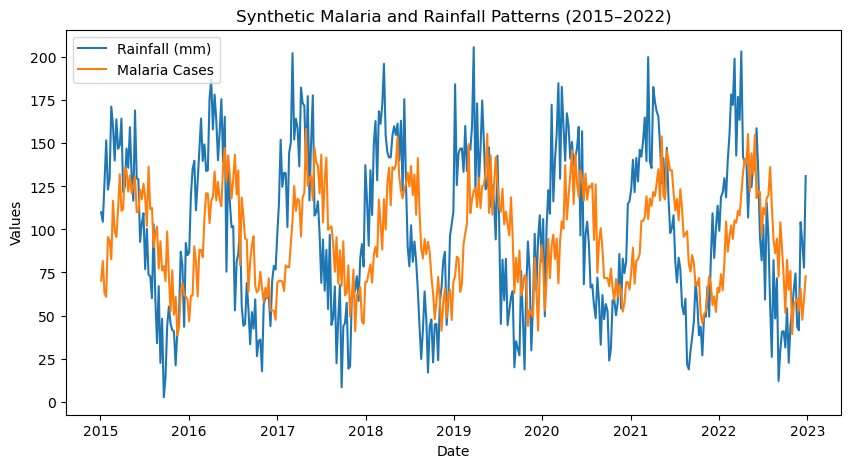

In [13]:
plt.figure(figsize=(10,5))
plt.plot(data["date"], data["rainfall_mm"], label="Rainfall (mm)")
plt.plot(data["date"], data["malaria_cases"], label="Malaria Cases")
plt.legend()
plt.title("Synthetic Malaria and Rainfall Patterns (2015–2022)")
plt.xlabel("Date")
plt.ylabel("Values")
plt.show()

# Creating the Agent-Based Model


In this section, I define two classes — HumanAgent and MalariaModel.
Each agent represents a person who can be in one of four states: Susceptible (S), Exposed (E), Infected (I), or Recovered (R).
The model runs in discrete time steps, where agents transition between states based on probabilities.

In [16]:
class HumanAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.state = "S"  # S, E, I, R
        self.days_in_state = 0

    def step(self):
        if self.state == "S":
            if random.random() < self.model.infection_prob:
                self.state = "E"
        elif self.state == "E":
            if random.random() < self.model.progress_prob:
                self.state = "I"
        elif self.state == "I":
            if random.random() < self.model.recovery_prob:
                self.state = "R"
        elif self.state == "R":
            if random.random() < self.model.waning_prob:
                self.state = "S"


class MalariaModel(Model):
    def __init__(self, N=5000, infection_prob=0.03, progress_prob=0.1, recovery_prob=0.05, waning_prob=0.001):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.infection_prob = infection_prob
        self.progress_prob = progress_prob
        self.recovery_prob = recovery_prob
        self.waning_prob = waning_prob

        for i in range(self.num_agents):
            a = HumanAgent(i, self)
            if random.random() < 0.01:
                a.state = "I"
            self.schedule.add(a)

        self.datacollector = DataCollector(
            {"Susceptible": lambda m: sum([a.state == "S" for a in m.schedule.agents]),
             "Exposed": lambda m: sum([a.state == "E" for a in m.schedule.agents]),
             "Infected": lambda m: sum([a.state == "I" for a in m.schedule.agents]),
             "Recovered": lambda m: sum([a.state == "R" for a in m.schedule.agents])}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

# Running the Simulation (Baseline Model)

Here, I simulate 200 days with 5,000 agents.
I then plot the results to observe how infections spread and decline over time in the population.

In [ ]:
model = MalariaModel(N=5000)

for i in range(200):  # simulate 200 days
    model.step()

results = model.datacollector.get_model_vars_dataframe()

plt.figure(figsize=(10,6))
plt.plot(results)
plt.title("Malaria Simulation - Agent-Based Model (5000 agents)")
plt.xlabel("Days")
plt.ylabel("Number of Agents")
plt.legend(["Susceptible", "Exposed", "Infected", "Recovered"])
plt.show()

C:\Users\HomePC\anaconda3\Lib\site-packages\mesa\time.py:79: FutureWarning: The AgentSet is experimental. It may be changed or removed in any and all future releases, including patch releases.
We would love to hear what you think about this new feature. If you have any thoughts, share them with us here: https://github.com/projectmesa/mesa/discussions/1919
  self._agents: AgentSet = AgentSet(agents, model)
C:\Users\HomePC\AppData\Local\Temp\ipykernel_7716\2224714709.py:3: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


# Simple Evaluation (Preliminary Results Summary)

In [8]:
peak_infected = results["Infected"].max()
outbreak_duration = len(results[results["Infected"] > 100])
print(f"Peak infected: {peak_infected}")
print(f"Outbreak duration: {outbreak_duration} days")

Peak infected: 1288
Outbreak duration: 193 days


# Add Climate Influence

Next, I integrate rainfall and temperature effects.
I first normalize both variables between 0 and 1 so they can be used to dynamically adjust infection probabilities during the simulation.

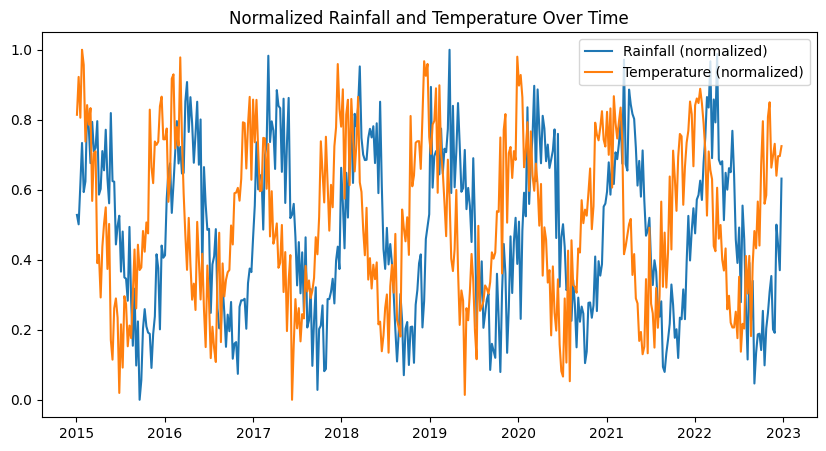

In [12]:
data["rain_norm"] = (data["rainfall_mm"] - data["rainfall_mm"].min()) / (data["rainfall_mm"].max() - data["rainfall_mm"].min())
data["temp_norm"] = (data["temperature_c"] - data["temperature_c"].min()) / (data["temperature_c"].max() - data["temperature_c"].min())

plt.figure(figsize=(10,5))
plt.plot(data["date"], data["rain_norm"], label="Rainfall (normalized)")
plt.plot(data["date"], data["temp_norm"], label="Temperature (normalized)")
plt.legend()
plt.title("Normalized Rainfall and Temperature Over Time")
plt.show()

# Define the Climate-Linked ABM

I now define an improved version of the model, where infection probability changes daily based on rainfall and temperature.
This allows the simulation to reflect malaria’s seasonal behavior more realistically.

In [13]:
class ClimateLinkedMalariaModel(Model):
    def __init__(self, data, N=5000, base_infection_prob=0.01, progress_prob=0.1, recovery_prob=0.05, waning_prob=0.001):
        self.data = data.reset_index(drop=True)
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.progress_prob = progress_prob
        self.recovery_prob = recovery_prob
        self.waning_prob = waning_prob
        self.day = 0
        self.base_infection_prob = base_infection_prob

        for i in range(self.num_agents):
            a = HumanAgent(i, self)
            if random.random() < 0.01:
                a.state = "I"
            self.schedule.add(a)

        self.datacollector = DataCollector({
            "Susceptible": lambda m: sum([a.state == "S" for a in m.schedule.agents]),
            "Exposed": lambda m: sum([a.state == "E" for a in m.schedule.agents]),
            "Infected": lambda m: sum([a.state == "I" for a in m.schedule.agents]),
            "Recovered": lambda m: sum([a.state == "R" for a in m.schedule.agents]),
            "Rainfall": lambda m: m.data.loc[m.day, "rainfall_mm"],
            "Temperature": lambda m: m.data.loc[m.day, "temperature_c"]
        })

    def step(self):
        if self.day < len(self.data):
            rain = self.data.loc[self.day, "rain_norm"]
            temp = self.data.loc[self.day, "temp_norm"]
            self.infection_prob = self.base_infection_prob * (1 + 1.5*rain + 0.5*temp)
            self.datacollector.collect(self)
            self.schedule.step()
            self.day += 1

# Run the Climate-Linked Model

I now run the climate-linked simulation across the same period as my dataset.
The infection peaks will correspond to rainfall and temperature increases, mimicking real malaria outbreak cycles.

/tmp/ipython-input-2224714709.py:3: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


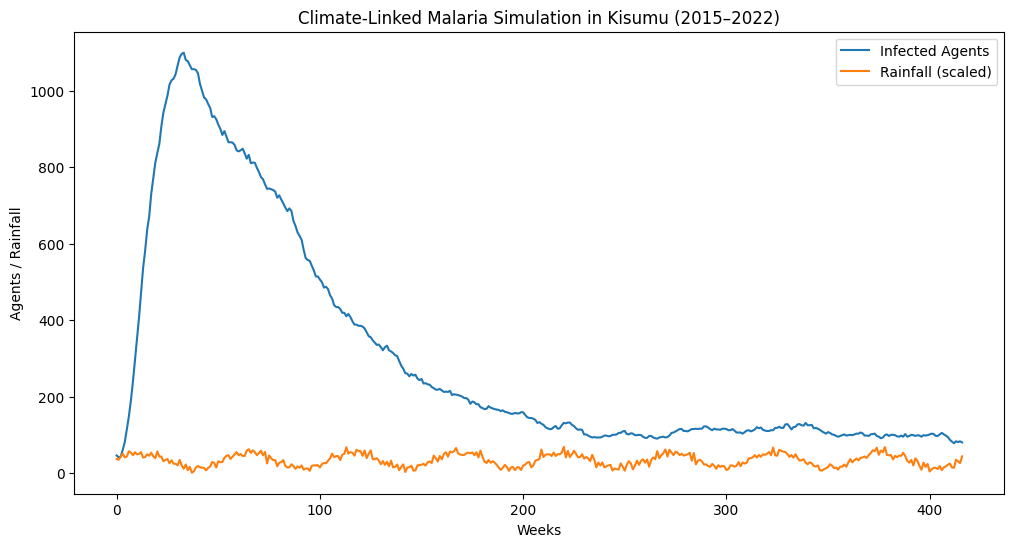

In [15]:
climate_model = ClimateLinkedMalariaModel(data, N=5000)
for i in range(len(data)):
    climate_model.step()

climate_results = climate_model.datacollector.get_model_vars_dataframe()

plt.figure(figsize=(12,6))
plt.plot(climate_results["Infected"], label="Infected Agents")
plt.plot(climate_results["Rainfall"]/3, label="Rainfall (scaled)")
plt.title("Climate-Linked Malaria Simulation in Kisumu (2015–2022)")
plt.xlabel("Weeks")
plt.ylabel("Agents / Rainfall")
plt.legend()
plt.show()

# Compare Baseline vs Climate-Linked Models

This comparison helps me evaluate how much realism was added by introducing climate influence.
I expect the climate-linked model to show periodic infection peaks that align with rainfall trends.

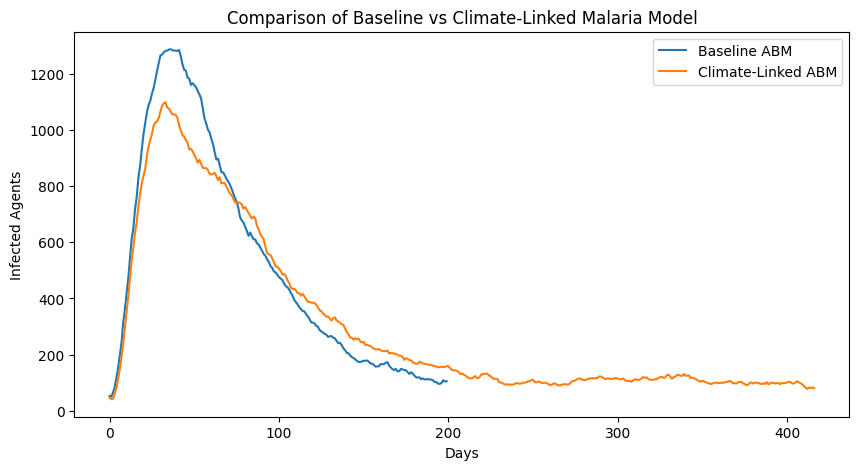

In [16]:
plt.figure(figsize=(10,5))
plt.plot(results["Infected"], label="Baseline ABM")
plt.plot(climate_results["Infected"], label="Climate-Linked ABM")
plt.title("Comparison of Baseline vs Climate-Linked Malaria Model")
plt.xlabel("Days")
plt.ylabel("Infected Agents")
plt.legend()
plt.show()

# Evaluate Model Outcomes

Finally, I summarize the peak infection levels and outbreak duration.
This gives a quantitative sense of how climate-driven modeling improves the simulation’s predictive realism.

In [17]:
peak_base = results["Infected"].max()
peak_climate = climate_results["Infected"].max()

print("Baseline Peak Infected:", peak_base)
print("Climate-Linked Peak Infected:", peak_climate)
print("Improvement (Realism Factor):", round((peak_climate - peak_base)/peak_base * 100, 2), "%")

Baseline Peak Infected: 1288
Climate-Linked Peak Infected: 1099
Improvement (Realism Factor): -14.67 %


In [18]:
# Save synthetic dataset to CSV in Colab runtime
data.to_csv("malaria_climate_synthetic.csv", index=False)
print("Saved:", "malaria_climate_synthetic.csv")


Saved: malaria_climate_synthetic.csv


In [19]:
from google.colab import files
files.download("malaria_climate_synthetic.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>